In [1]:
# Import of relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression

In [2]:
RSEED = 42

In [28]:
def prepForModel(df):
    drop_cols = [
        'blurb',
        'creator',
        'currency',
        'currency_trailing_code',
        'fx_rate',
        'location',
        'name',
        'profile',
        'slug',
        'source_url',
        'static_usd_rate',
        'usd_type',
        'spotlight'
    ]
    df.drop(drop_cols, inplace=True, axis = 1)
    for c in df.columns: 
        if df[c].dtype == "object": 
            df[c] = df[c].astype("category") 
    df.dropna(inplace=True)
    return df

In [29]:
df = pd.read_csv('data/df_clean.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.head()

backers_count                                              blurb  \
0              2  Sreap aims to be the news article platform of ...   
1              2  A short film drama about family and life on th...   
2            119  We're establishing permanent home for our deli...   
3             70  Honoring the abandoned house on John St with a...   
4             73  Send Austin's youth slam team to Nationals in ...   

   converted_pledged_amount country  created_at  \
0                         2      CA  1540305218   
1                         2      US  1462569183   
2                      5635      US  1483369959   
3                      1317      US  1325637522   
4                      5134      US  1301344770   

                                             creator currency  \
0  {"id":1378912800,"name":"Jack Rayner","is_regi...      CAD   
1  {"id":619766856,"name":"Stephan Denash Giacoma...      USD   
2  {"id":1692472044,"name":"Katie Startzman","slu...      USD   
3  {"id":268837772,"name":"Patrick Steele","is_re...      USD   
4  {"id":1873668274,"name":"Sky Candy","slug":"sk...      USD   

   currency_trailing_code    deadline  disable_communication  ...  spotlight  \
0                    True  1542900780                  False  ...      False   
1                    True  1471994797                  False  ...      False   
2                    True  1487595600                  False  ...       True   
3                    True  1331530353                  False  ...       True   
4                    True  1306558117                  False  ...       True   

   staff_pick       state  state_changed_at static_usd_rate  usd_pledged  \
0       False      failed        1542900780         0.76388     2.513164   
1       False      failed        1471994797         1.00000     2.000000   
2       False  successful        1487595600         1.00000  5635.000000   
3       False  successful        1331530353         1.00000  1317.690000   
4       False  successful        1306558117         1.00000  5134.010000   

        usd_type   category_name          category_slug cgrouped  
0  international             Web         journalism/web       CA  
1  international           Drama     film & video/drama       US  
2  international     Restaurants       food/restaurants       US  
3  international  Graphic Design  design/graphic design       US  
4  international          Poetry      publishing/poetry       US  

[5 rows x 30 columns]

In [30]:
df = prepForModel(df)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187660 entries, 0 to 187659
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   backers_count             187660 non-null  int64   
 1   converted_pledged_amount  187660 non-null  int64   
 2   country                   187660 non-null  category
 3   created_at                187660 non-null  int64   
 4   deadline                  187660 non-null  int64   
 5   disable_communication     187660 non-null  bool    
 6   goal                      187660 non-null  float64 
 7   is_starrable              187660 non-null  bool    
 8   launched_at               187660 non-null  int64   
 9   pledged                   187660 non-null  float64 
 10  staff_pick                187660 non-null  bool    
 11  state                     187660 non-null  category
 12  state_changed_at          187660 non-null  int64   
 13  usd_pledged               187

In [32]:
# Drop rows with state categories live, canceled & suspended
# (just for fun)
df_fun = df[(df['state']=='failed') | (df['state']=='successful')]
df_fun.state.unique()
df = df_fun

In [33]:
# Creating list for categorical predictors/features 
# (dates are also objects so if you have them in your data you would deal with them first)
cat_features = list(df.columns[df.dtypes=='category'])
cat_features.remove('state')
cat_features

['country', 'category_name', 'category_slug', 'cgrouped']

In [34]:
# Creating list for numerical predictors/features
# Since 'Survived' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = list(df.columns[df.dtypes!='category'])
num_features

['backers_count',
 'converted_pledged_amount',
 'created_at',
 'deadline',
 'disable_communication',
 'goal',
 'is_starrable',
 'launched_at',
 'pledged',
 'staff_pick',
 'state_changed_at',
 'usd_pledged']

In [35]:
df[num_features].head(10)

backers_count  converted_pledged_amount  created_at    deadline  \
0              2                         2  1540305218  1542900780   
1              2                         2  1462569183  1471994797   
2            119                      5635  1483369959  1487595600   
3             70                      1317  1325637522  1331530353   
4             73                      5134  1301344770  1306558117   
5            151                     13268  1413254817  1416783493   
6             79                      1323  1541843459  1550478074   
7           2129                     80977  1360622868  1365735600   
8             94                      6620  1410225399  1414382340   
9            121                      8200  1473337313  1478811600   

   disable_communication     goal  is_starrable  launched_at   pledged  \
0                  False  30000.0         False   1540308166      3.29   
1                  False  70000.0         False   1468106797      2.00   
2                  False   4000.0         False   1486386355   5635.00   
3                  False    500.0         False   1329719553   1317.69   
4                  False   5000.0         False   1303102117   5134.01   
5                  False  12000.0         False   1414187893  13268.00   
6                  False    550.0         False   1546158074   1850.32   
7                  False  75000.0         False   1362686869  80977.69   
8                  False   6350.0         False   1412018766   6620.01   
9                  False   6200.0         False   1476088218   6608.00   

   staff_pick  state_changed_at   usd_pledged  
0       False        1542900780      2.513164  
1       False        1471994797      2.000000  
2       False        1487595600   5635.000000  
3       False        1331530353   1317.690000  
4       False        1306558117   5134.010000  
5       False        1416783495  13268.000000  
6       False        1550478074   1303.365334  
7        True        1365735635  80977.690000  
8       False        1414382341   6620.010000  
9        True        1478811600   8217.219081

In [36]:
# Define predictors and target variable
X = df.drop('state', axis=1)
y = df['state']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 173168 observations in our dataset and 16 features
Our target vector has also 173168 values


In [37]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [38]:
# Pipline for numerical features
# Initiating Pipeline and calling one step after another
# each step is built as a list of (key, value)
# key is the name of the processing step
# value is an estimator object (processing step)
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [39]:
# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [40]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=20))
])

In [41]:
# Making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe_logreg, X_train, y_train, cv=5, n_jobs=-1)

In [42]:
# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted, pos_label='successful')))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted, pos_label='successful')))

Cross validation scores:
-------------------------
Accuracy: 0.88
Recall: 0.87
Precision: 0.93


In [43]:
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'logreg') in our pipeline 
# we have to add 'logreg__' infront of the corresponding hyperparameters. 
param_logreg = {'logreg__C': [0.01, 0.1, 1, 10]
               }

grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

In [44]:
grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/juliusjenek/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['backers_count',
                                                                          'converted_pledged_amount',
                                                                          'created_at',
                                                                          'deadline',
                                 

In [45]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters:\n{}".format(grid_logreg.best_params_))

Best score:
0.88
Best parameters:
{'logreg__C': 10}


In [46]:
# Save best model as best_model
best_model = grid_logreg.best_estimator_['logreg']

In [47]:
# Preparing the test set 

# fitting our preprocessing pipeline only with training data
preprocessor.fit(X_train)
# transforming our test data with fitted preprocessor pipeline
X_test_preprocessed = preprocessor.transform(X_test)

In [49]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted = best_model.predict(X_test_preprocessed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted, pos_label='successful')))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted, pos_label='successful')))

Accuracy: 0.89
Recall: 0.88
Precision: 0.93


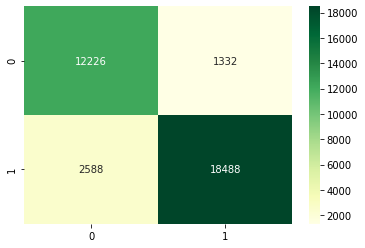

In [51]:
# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_test_predicted), annot=True, cmap='YlGn', fmt='d');

In [23]:
from pandas_profiling import ProfileReport

In [25]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative = True)

In [26]:
profile

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
df.corr()

backers_count  converted_pledged_amount  created_at  \
backers_count                  1.000000                  0.789663    0.028706   
converted_pledged_amount       0.789663                  1.000000    0.036229   
created_at                     0.028706                  0.036229    1.000000   
deadline                       0.034670                  0.042017    0.983346   
disable_communication               NaN                       NaN         NaN   
goal                           0.012146                  0.011737    0.004345   
is_starrable                        NaN                       NaN         NaN   
launched_at                    0.034500                  0.041562    0.983563   
pledged                        0.247104                  0.309476    0.029992   
spotlight                      0.124039                  0.111804    0.019518   
staff_pick                     0.157386                  0.145768   -0.041341   
state_changed_at               0.034671                  0.042017    0.983346   
usd_pledged                    0.789534                  0.999973    0.036286   

                          deadline  disable_communication      goal  \
backers_count             0.034670                    NaN  0.012146   
converted_pledged_amount  0.042017                    NaN  0.011737   
created_at                0.983346                    NaN  0.004345   
deadline                  1.000000                    NaN  0.005097   
disable_communication          NaN                    NaN       NaN   
goal                      0.005097                    NaN  1.000000   
is_starrable                   NaN                    NaN       NaN   
launched_at               0.999870                    NaN  0.004594   
pledged                   0.031772                    NaN  0.148242   
spotlight                 0.023114                    NaN -0.035547   
staff_pick               -0.032871                    NaN -0.003677   
state_changed_at          1.000000                    NaN  0.005097   
usd_pledged               0.042083                    NaN  0.011841   

                          is_starrable  launched_at   pledged  spotlight  \
backers_count                      NaN     0.034500  0.247104   0.124039   
converted_pledged_amount           NaN     0.041562  0.309476   0.111804   
created_at                         NaN     0.983563  0.029992   0.019518   
deadline                           NaN     0.999870  0.031772   0.023114   
disable_communication              NaN          NaN       NaN        NaN   
goal                               NaN     0.004594  0.148242  -0.035547   
is_starrable                       NaN          NaN       NaN        NaN   
launched_at                        NaN     1.000000  0.031529   0.025631   
pledged                            NaN     0.031529  1.000000   0.044064   
spotlight                          NaN     0.025631  0.044064   1.000000   
staff_pick                         NaN    -0.032528  0.062315   0.245096   
state_changed_at                   NaN     0.999870  0.031772   0.023115   
usd_pledged                        NaN     0.041628  0.309887   0.111799   

                          staff_pick  state_changed_at  usd_pledged  
backers_count               0.157386          0.034671     0.789534  
converted_pledged_amount    0.145768          0.042017     0.999973  
created_at                 -0.041341          0.983346     0.036286  
deadline                   -0.032871          1.000000     0.042083  
disable_communication            NaN               NaN          NaN  
goal                       -0.003677          0.005097     0.011841  
is_starrable                     NaN               NaN          NaN  
launched_at                -0.032528          0.999870     0.041628  
pledged                     0.062315          0.031772     0.309887  
spotlight                   0.245096          0.023115     0.111799  
staff_pick                  1.000000         -0.032871     0.